# My attempt of creating a MLP neural network for predicting the flag.

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn

###Let's define constants for this code

In [217]:
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 0.001

In [218]:
dataset = pd.read_csv("/home/grzesiek/documents/programming/machine_learning/neuron/warsztat-ai/datasets/autentykacja_eeg.csv", delimiter=";")
dataset.head()

,Delta,Theta,Alpha_low,Alpha_high,Beta_low,Beta_high,Gamma_low,Gamma_high,Attention,Meditation,BlinkStrength,Flag
0,785389,114375,57106,37625,24464,17104,15846,8024,45,91,15,1
1,386949,80792,23506,22118,9566,7147,5392,1697,8,42,6,0
2,21453,14085,4756,5062,2176,2117,2867,862,48,66,9,1
3,322637,56936,17810,25793,15870,8050,3621,2100,25,69,8,0
4,19412,12985,6416,6131,7126,7419,2677,1884,80,53,-1,1


In [219]:
# Try creating validation sets next time
X = torch.tensor(dataset.loc[:, "Delta": "BlinkStrength"].values, dtype=torch.float32)
y = torch.tensor(dataset.Flag.values, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [220]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4195, 11]),
 torch.Size([1049, 11]),
 torch.Size([4195]),
 torch.Size([1049]))

In [221]:
y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)

## Let's create a datasets and proceed so we can make a dataloaders out of them.

In [222]:
def create_dataloader(X_train, y_train, X_test, y_test):
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    
    )
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    print(f"Train DataLoader length: {len(train_dataloader)} | Batch Size: {BATCH_SIZE}")
    print(f"Test DataLoader length: {len(test_dataloader)} | Batch Size: {BATCH_SIZE}")
    return train_dataloader, test_dataloader

In [223]:
train_dataloader, test_dataloader = create_dataloader(X_train, y_train, X_test, y_test)

Train DataLoader length: 132 | Batch Size: 32
Test DataLoader length: 33 | Batch Size: 32


## First of all, I'll try to train my neural network on unchanged data.

In [224]:
input = len(dataset.columns.values) - 1
output = 1


class FlagModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.Sigmoid(),
            
        )

    def forward(self, x):
        return self.block_1(x)


flag_model_1 = FlagModel(input, 33, output).to(device)
flag_model_1

FlagModel(
  (block_1): Sequential(
    (0): Linear(in_features=11, out_features=33, bias=True)
    (1): ReLU()
    (2): Linear(in_features=33, out_features=33, bias=True)
    (3): ReLU()
    (4): Linear(in_features=33, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [225]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> [torch.float]:
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(params=flag_model_1.parameters(), lr=LEARNING_RATE)

In [226]:
# TODO use sigmoid in model, not train

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.train()

    for batch in data_loader:
        X, y = batch
        X, y = X.to(device), y.to(device)
        logits = model(X)
        pred = torch.round(logits)

        loss = loss_fn(logits, y)
        acc = accuracy_fn(y_true=y, y_pred=pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += acc

    return train_loss / len(data_loader), train_acc / len(data_loader)


In [227]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device:torch.device = device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        
        for batch in data_loader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            logits = model(X)
            pred = torch.round(logits)
            loss = loss_fn(logits, y)
            acc = accuracy_fn(y_true=y, y_pred=pred)

            test_loss += loss
            test_acc += acc

        return loss, acc



In [228]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

train_time_start = timer()

torch.manual_seed(42)

def train(model: torch.nn.Module,
          train_data: torch.utils.data.DataLoader,
          test_data: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          epochs: int,
          device:torch.device = device):

    for epoch in tqdm(range(EPOCHS)):
        train_loss, train_acc = train_step(model=model,
                                        data_loader=train_data,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        accuracy_fn=accuracy_fn,
                                        device=device)
        test_loss, test_acc = test_step(model=model,
                                        data_loader=test_data,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn,
                                        device=device)


        print(f"\nEpoch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f}% | Test loss: {test_loss} | Test Acc: {test_acc:.2f}%")

    train_time_end = timer()
    print(f"\nTraining was done in {(train_time_end - train_time_start):.2f} seconds")

In [229]:
train(model=flag_model_1,
      train_data=train_dataloader,
      test_data=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      epochs=EPOCHS)

 50%|█████     | 2/4 [00:00<00:00,  5.37it/s]


Epoch: 0 | Train Loss: 40.57 | Train Acc: 59.37% | Test loss: 52.0 | Test Acc: 48.00%

Epoch: 1 | Train Loss: 40.51 | Train Acc: 59.49% | Test loss: 52.0 | Test Acc: 48.00%


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch: 2 | Train Loss: 40.74 | Train Acc: 59.26% | Test loss: 52.0 | Test Acc: 48.00%

Epoch: 3 | Train Loss: 40.51 | Train Acc: 59.49% | Test loss: 52.0 | Test Acc: 48.00%

Training was done in 0.76 seconds


# Since predicting on unchanged data wasn't fruitful I'll try to modify them using log function

In [230]:
dataset.loc[dataset['BlinkStrength'] < 0]

def log_transform(data, col, unchanged):
   new_dataset = pd.DataFrame()
   for colname in col:
        new_dataset[colname + '_log'] = np.log(data[colname]+1)

   new_dataset[unchanged] = data[unchanged]
   new_dataset['Flag'] = data['Flag']
   return new_dataset


transformed_dataset = log_transform(dataset,
                                    ['Delta', 'Theta', 'Alpha_low', 'Alpha_high', 'Beta_low', 'Beta_high', 'Gamma_low', 'Gamma_high'],
                                    ["Attention", "Meditation", "Flag"])
transformed_dataset.describe()
# dataset[["Attention", "Meditation", "BlinkStrength"]]

,Delta_log,Theta_log,Alpha_low_log,Alpha_high_log,Beta_low_log,Beta_high_log,Gamma_low_log,Gamma_high_log,Attention,Meditation,Flag
count,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000
mean,12.064500,10.695941,9.355392,9.250890,9.035782,8.828616,8.406818,7.724752,51.652365,58.632151,0.601068
std,1.189917,0.825552,0.761348,0.684732,0.668153,0.631344,0.737807,0.716020,16.511836,15.025158,0.489725
min,8.430545,8.368229,7.257003,7.109879,7.007601,7.074963,6.326149,5.529429,1.000000,1.000000,0.000000
25%,11.211986,10.105826,8.807921,8.773810,8.601534,8.414274,7.892732,7.246368,40.000000,49.000000,0.000000
50%,12.172185,10.610858,9.293578,9.184099,8.987822,8.794673,8.368229,7.678326,52.000000,59.000000,1.000000
75%,13.050982,11.287742,9.841825,9.680828,9.423131,9.195531,8.887480,8.168203,63.000000,69.000000,1.000000
max,14.425741,13.445089,12.033842,11.912916,12.027843,12.066293,11.105949,10.232324,100.000000,99.000000,1.000000


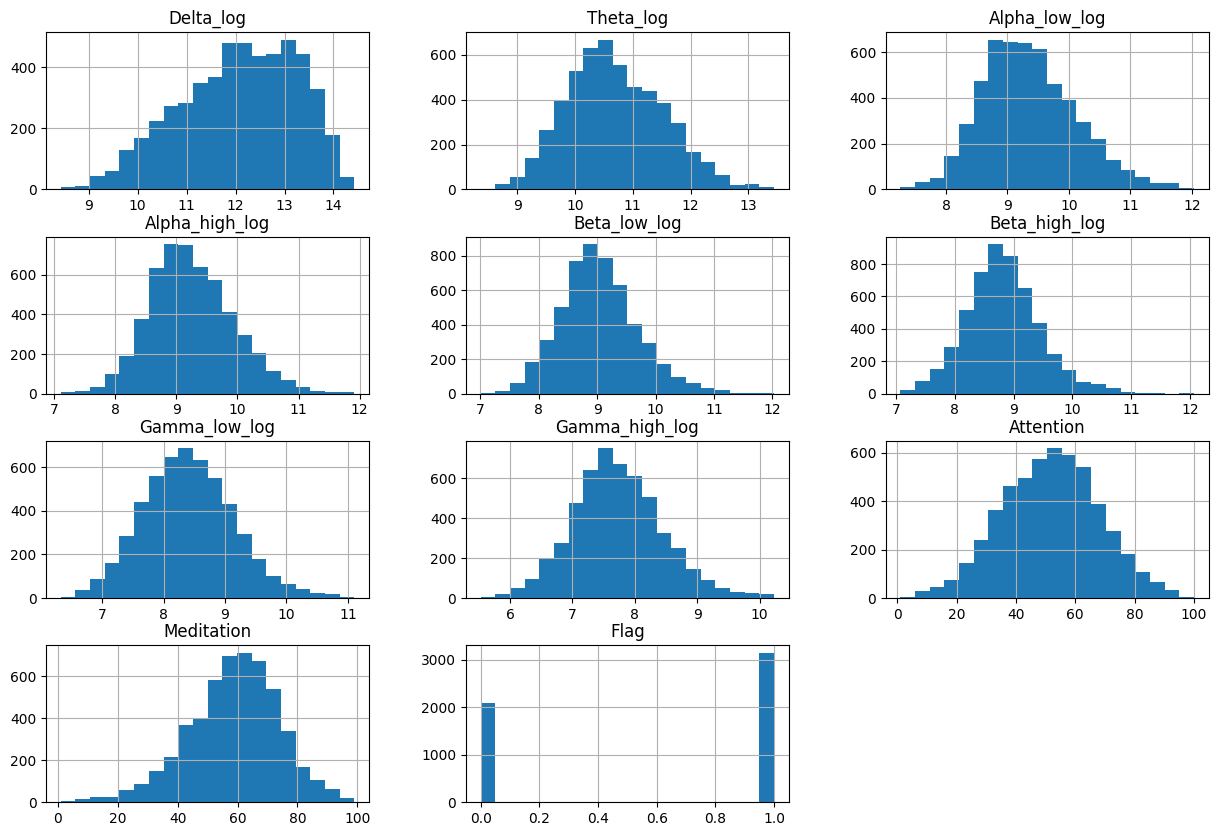

In [231]:
transformed_dataset.hist(figsize=(15,10), bins = 20)
plt.title("Features Distribution")
plt.show()

In [232]:
X2 = torch.tensor(transformed_dataset.loc[:, "Delta_log": "Meditation"].values, dtype=torch.float32)
y2 = torch.tensor(transformed_dataset.Flag.values, dtype=torch.float32)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=1)

y_train_2 = y_train_2.unsqueeze(1)
y_test_2 = y_test_2.unsqueeze(1)

train_dataloader_2, test_dataloader_2 = create_dataloader(X_train_2, y_train_2, X_test_2, y_test_2)

Train DataLoader length: 132 | Batch Size: 32
Test DataLoader length: 33 | Batch Size: 32


In [233]:
class FlagModel2(nn.Module):
   def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
       super().__init__()

       self.block_1 = nn.Sequential(
           nn.Linear(in_features=input_shape, out_features=hidden_units),
           nn.ReLU(),
           nn.Linear(in_features=hidden_units, out_features=hidden_units),
           nn.ReLU(),
           nn.Linear(in_features=hidden_units, out_features=hidden_units),
       )
       self.block_2 = nn.Sequential(
           nn.ReLU(),
           nn.Linear(in_features=hidden_units, out_features=output_shape),
           nn.Sigmoid()
       )

   def forward(self, x):
       return self.block_2(self.block_1(x))

flag_model_2 = FlagModel2(11, 24, 1).to(device)
flag_model_2

FlagModel2(
  (block_1): Sequential(
    (0): Linear(in_features=11, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=24, bias=True)
  )
  (block_2): Sequential(
    (0): ReLU()
    (1): Linear(in_features=24, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [234]:
EPOCHS = 10
optimizer = torch.optim.Adam(params=flag_model_2.parameters(), lr=0.001)

In [235]:
train(model=flag_model_2,
      train_data=train_dataloader_2,
      test_data=test_dataloader_2,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      epochs=EPOCHS)

 10%|█         | 1/10 [00:00<00:03,  2.56it/s]


Epoch: 0 | Train Loss: 40.51 | Train Acc: 59.49% | Test loss: 52.0 | Test Acc: 48.00%


 30%|███       | 3/10 [00:00<00:01,  3.65it/s]


Epoch: 1 | Train Loss: 40.29 | Train Acc: 59.71% | Test loss: 52.0 | Test Acc: 48.00%

Epoch: 2 | Train Loss: 40.29 | Train Acc: 59.71% | Test loss: 52.0 | Test Acc: 48.00%


 50%|█████     | 5/10 [00:01<00:01,  4.80it/s]


Epoch: 3 | Train Loss: 40.29 | Train Acc: 59.71% | Test loss: 52.0 | Test Acc: 48.00%

Epoch: 4 | Train Loss: 40.06 | Train Acc: 59.94% | Test loss: 52.0 | Test Acc: 48.00%


 70%|███████   | 7/10 [00:01<00:00,  5.43it/s]


Epoch: 5 | Train Loss: 40.74 | Train Acc: 59.26% | Test loss: 52.0 | Test Acc: 48.00%

Epoch: 6 | Train Loss: 40.29 | Train Acc: 59.71% | Test loss: 52.0 | Test Acc: 48.00%


 90%|█████████ | 9/10 [00:01<00:00,  5.68it/s]


Epoch: 7 | Train Loss: 40.51 | Train Acc: 59.49% | Test loss: 52.0 | Test Acc: 48.00%

Epoch: 8 | Train Loss: 40.29 | Train Acc: 59.71% | Test loss: 52.0 | Test Acc: 48.00%


100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch: 9 | Train Loss: 40.29 | Train Acc: 59.71% | Test loss: 52.0 | Test Acc: 48.00%

Training was done in 4.67 seconds
